In [313]:
# !pip install -q transformers

# !pip install -q datasets

# !pip install -q evaluate

# !pip install -q accelerate

# !pip install -q gluonts ujson

# !pip install -q matplotlib

# !pip install scikit-learn

In [314]:
# IMPORTS:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [315]:
# Read data file
path = "data.csv"
df = pd.read_csv(path,sep=',', header=0,index_col=False)

# Prorocess
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
df.ffill(inplace=True)  # Forward fill NaNs (fill with last valid value)

# Add features
df['feat_static_cat'] = df['ID'].astype(int)
df['ID'] = df['ID'].astype(int).astype(str)
df.rename(columns={'time': 'start'}, inplace=True)

timedeltas= pd.to_timedelta(df['start'],unit='S')
df['start'] = pd.Timestamp('2024-01-01')+timedeltas

print(len(df['start']))
print(df.shape)
print(df.head())
#print(df['start'])

3000
(3000, 5)
                          start         u         x ID  feat_static_cat
0 2024-01-01 00:00:00.000000000  0.250000  0.125000  1                1
1 2024-01-01 00:00:00.001001001  0.250125  0.126064  1                1
2 2024-01-01 00:00:00.002002002  0.250251  0.127127  1                1
3 2024-01-01 00:00:00.003003003  0.250376  0.128191  1                1
4 2024-01-01 00:00:00.004004004  0.250502  0.129255  1                1


In [316]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset.from_long_dataframe(df, target=["u","x"], item_id="ID")
print(ds)



PandasDataset<size=3, freq=N, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>


In [317]:
class ProcessStartField():
    ts_id = 0
    
    def __call__(self, data):
        data["start"] = data["start"].to_timestamp()
        data["feat_static_cat"] = [self.ts_id]
        self.ts_id += 1
        
        return data

In [318]:
from gluonts.itertools import Map

process_start = ProcessStartField()

list_ds = list(Map(process_start, ds))

In [319]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [320]:
from datasets import Dataset, Features, Value, Sequence

features  = Features(
    {    
        "start": Value("timestamp[us]"),
        "target": Sequence(Sequence(Value("float32"))),
        # "feat_static_real":  Sequence(Value("float32")),
        # "feat_dynamic_real": Sequence(Sequence(Value("uint64"))),
        # "feat_dynamic_cat": Sequence(Sequence(Value("uint64"))),
        "item_id": Value("string"),
        "feat_static_cat": Sequence(Value("uint64")),
    }
)

In [321]:

#print(list_ds)

dataset = Dataset.from_list(list_ds, features=features)
print(len(dataset[0]['target'][0]))
print(dataset[0]['start'])

1000
1970-01-01 00:00:00


In [322]:
from functools import partial
freq = '1s'
dataset.set_transform(partial(transform_start_field, freq=freq))
print(dataset)

Dataset({
    features: ['start', 'target', 'item_id', 'feat_static_cat'],
    num_rows: 3
})


In [323]:
from gluonts.dataset.common import ListDataset
import copy

def split_gluonts_dataset(dataset, train_frac=0.8, val_frac=0.1):
    # Initialize empty lists for train, validation, and test datasets
    train_ds = []
    val_ds = []
    test_ds = []

    total_length = len(dataset[0]['target'][0])
    train_end = int(total_length * train_frac)
    val_end = train_end + int(total_length * val_frac)
    print(total_length,train_end, val_end)
    # Iterate over each series in the dataset
    for series in dataset:
        # Append the sliced series to the respective dataset lists 
        train_ds.append({'target': (series['target'][0][:train_end],series['target'][1][:train_end]), 'start': series.get('start'), 'item_id': series.get('item_id'), 'feat_static_cat': series.get('feat_static_cat')})
        val_ds.append({'target': (series['target'][0][:val_end],series['target'][1][:val_end]), 'start': series.get('start'), 'item_id': series.get('item_id'),'feat_static_cat': series.get('feat_static_cat')})
        test_ds.append({'target': (series['target'][0], series['target'][1]), 'start': series.get('start'), 'item_id': series.get('item_id'),'feat_static_cat': series.get('feat_static_cat')})

        # train_ds.append({'target': (series['target'][0][:train_end],series['target'][1][:train_end]), 'start': df['start'][0], 'item_id': series.get('item_id'), 'feat_static_cat': series.get('feat_static_cat')})
        # val_ds.append({'target': (series['target'][0][train_end:val_end],series['target'][1][train_end:val_end]), 'start': df['start'][train_end], 'item_id': series.get('item_id'),'feat_static_cat': series.get('feat_static_cat')})
        # test_ds.append({'target': (series['target'][0][val_end:], series['target'][1][val_end:]), 'start': df['start'][val_end], 'item_id': series.get('item_id'),'feat_static_cat': series.get('feat_static_cat')})

    return train_ds, val_ds, test_ds, val_end-train_end

In [324]:
# Split data
train_ds, val_ds, test_ds, prediction_length = split_gluonts_dataset(dataset, train_frac=0.6, val_frac=0.2)

# for set in [train_ds, val_ds, test_ds ]:
#     set = Dataset.from_list(set)
#     print(set)
#     set =  set.set_transform(partial(transform_start_field, freq=freq))
print(train_ds[0]) 

1000 600 800
{'target': ([0.25, 0.2501251995563507, 0.2502504885196686, 0.2503759264945984, 0.25050151348114014, 0.25062718987464905, 0.2507530152797699, 0.2508789598941803, 0.25100502371788025, 0.25113123655319214, 0.2512575387954712, 0.2513839900493622, 0.2515105605125427, 0.2516372799873352, 0.25176411867141724, 0.2518910765647888, 0.25201815366744995, 0.252145379781723, 0.25227272510528564, 0.2524001896381378, 0.25252780318260193, 0.2526555359363556, 0.2527833878993988, 0.25291138887405396, 0.25303950905799866, 0.2531677782535553, 0.2532961368560791, 0.25342464447021484, 0.2535533010959625, 0.25368207693099976, 0.25381097197532654, 0.25394001603126526, 0.25406917929649353, 0.25419846177101135, 0.2543278932571411, 0.2544574737548828, 0.2545871436595917, 0.25471699237823486, 0.2548469305038452, 0.2549770176410675, 0.25510725378990173, 0.2552376091480255, 0.25536808371543884, 0.2554987072944641, 0.2556294798851013, 0.2557603716850281, 0.2558913826942444, 0.25602254271507263, 0.2561538

In [325]:

# print(test_ds[0]['start'])
# print(train_ds[0]['start'])
print('dataset len',len(dataset[0]['target'][0]))
print('train len:', len(train_ds[0]['target'][0]))
print('val len:', len(val_ds[0]['target'][0]))
print('test len:', len(test_ds[0]['target'][0]))
print('pred_len', prediction_length)

dataset len 1000
train len: 600
val len: 800
test len: 1000
pred_len 200


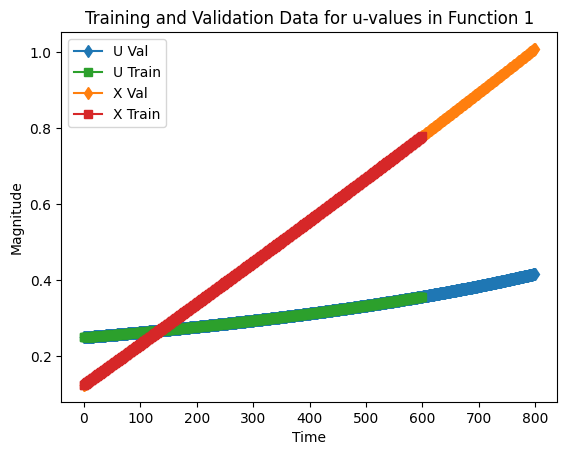

In [326]:
# import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(val_ds[0]["target"][0], 'd-',color='C0', label="U Val")
plt.plot(train_ds[0]["target"][0], 's-',color='C2', label="U Train")

plt.plot(val_ds[0]["target"][1], 'd-',color='C1', label="X Val")
plt.plot(train_ds[0]["target"][1], 's-',color='C3', label="X Train")
plt.title(f'Training and Validation Data for u-values in Function 1')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

# The validation set contains the same data as the training set, just for a prediction_length longer amount of time.
# The test set is again one prediction_length longer data compared to the validation set
assert len(train_ds[0]["target"][0]) + prediction_length == len(
    val_ds[0]["target"][0]
)

In [327]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)
print(len(dataset))

[<function second_of_minute at 0x000001ABBA176320>, <function minute_of_hour at 0x000001ABBA1764D0>, <function hour_of_day at 0x000001ABBA176200>, <function day_of_week at 0x000001ABBA1760E0>, <function day_of_month at 0x000001ABBA175FC0>, <function day_of_year at 0x000001ABBA176EF0>]
3


In [328]:
# Model definition

from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    
    # context length:
    context_length=prediction_length * 2,
    
    # lags coming from helper given the freq:
    lags_sequence=[1],
    
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) +1,
    
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features= 1,
    
    # it has 366 possible values:
    cardinality=[len(dataset)],
    
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    input_size = 2, # multivariate
    num_parallel_samples=1,
    # transformer params:
    activation_function="relu",
    encoder_attention_heads=2,
    decoder_attention_heads=2,
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)


In [329]:
# Note that, similar to other models in the 🤗 Transformers library, TimeSeriesTransformerModel corresponds to the encoder-decoder Transformer without any head on top, 
# and TimeSeriesTransformerForPrediction corresponds to TimeSeriesTransformerModel with a distribution head on top.
model.config.distribution_output

'student_t'

In [330]:
# data transformations

from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

In [331]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [332]:
# For training/validation/testing we next create an InstanceSplitter which is used to sample windows from the dataset 
# (as, remember, we can't pass the entire history of values to the Transformer due to time- and memory constraints).

#The instance splitter samples random context_length sized and subsequent prediction_length sized windows from the data, 
# and appends a past_ or future_ key to any temporal keys in time_series_fields for the respective windows. 
# The instance splitter can be configured into three different modes:
#       mode="train": Here we sample the context and prediction length windows randomly from the dataset given to it (the training dataset)
#       mode="validation": Here we sample the very last context length window and prediction window from the dataset given to it (for the back-testing or validation likelihood calculations)
#       mode="test": Here we sample the very last context length window only (for the prediction use case)

from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [333]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [334]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )
    
def create_backtest_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data)

    # we create a Validation Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in train mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=True)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )



In [335]:
freq ='1s'
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_ds,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=test_ds,
    batch_size=32,
)


In [336]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type()) # feature, targets, mask,
    
# As can be seen, we don't feed input_ids and attention_mask to the encoder (as would be the case for NLP models), 
# but rather past_values, along with past_observed_mask, past_time_features, and static_categorical_features.

# The decoder inputs consist of future_values, future_observed_mask and future_time_features. 
# The future_values can be seen as the equivalent of decoder_input_ids in NLP.

past_time_features torch.Size([256, 401, 7]) torch.FloatTensor
past_values torch.Size([256, 401, 2]) torch.FloatTensor
past_observed_mask torch.Size([256, 401, 2]) torch.FloatTensor
future_time_features torch.Size([256, 200, 7]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.IntTensor
future_values torch.Size([256, 200, 2]) torch.FloatTensor
future_observed_mask torch.Size([256, 200, 2]) torch.FloatTensor


In [337]:
# train model 

from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-5, betas=(0.8, 0.85), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

epochs = 10
loss_array = []
model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())
        loss_array.append(loss.item())

4.97312068939209
5.163521766662598
4.4984869956970215
4.340290069580078


KeyboardInterrupt: 

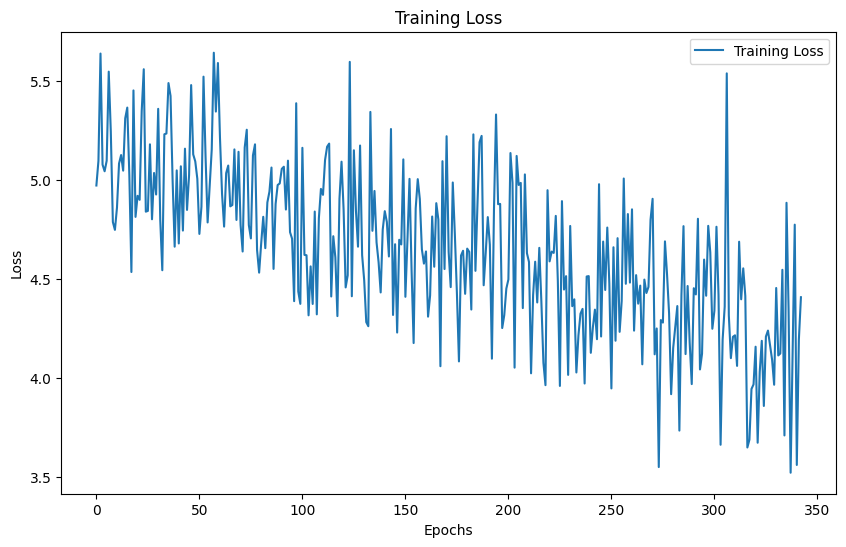

In [338]:
#Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_array, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
#inference
model.eval()

forecasts_ = []
device ="cpu"

for batch in test_dataloader:
    # Extract necessary components from batch
    static_cat_features = batch["static_categorical_features"].to(device) if config.num_static_categorical_features > 0 else None
    static_real_features = batch["static_real_features"].to(device) if config.num_static_real_features > 0 else None
    past_time_features = batch["past_time_features"].to(device)
    past_values = batch["past_values"].to(device)
    future_time_features = batch["future_time_features"].to(device)
    past_observed_mask = batch["past_observed_mask"].to(device)

    # Debugging shapes
    print(f"Past values shape: {past_values.shape}")
    print(f"Past time features shape: {past_time_features.shape}")
    print(f"Future time features shape: {future_time_features.shape}")

    
    outputs = model.generate(
        static_categorical_features=static_cat_features,
        static_real_features=static_real_features,
        past_time_features=past_time_features,
        past_values=past_values,
        future_time_features=future_time_features,
        past_observed_mask=past_observed_mask
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

Past values shape: torch.Size([3, 401, 2])
Past time features shape: torch.Size([3, 401, 7])
Future time features shape: torch.Size([3, 200, 7])


In [ ]:
print(forecasts_[0].shape)
forecasts_test = np.vstack(forecasts_)
print(forecasts_test.shape) #3 timeseries, 2 vars


(3, 1, 200, 2)
(3, 1, 200, 2)


[0.4169449210166931, 0.4172932207584381, 0.41764214634895325, 0.41799163818359375, 0.4183416962623596, 0.41869238018989563, 0.419043630361557, 0.41939547657966614, 0.41974788904190063, 0.4201009273529053, 0.4204545319080353, 0.4208087623119354, 0.4211635887622833, 0.4215189814567566, 0.421875, 0.42223161458969116, 0.4225888252258301, 0.42294666171073914, 0.42330509424209595, 0.4236641228199005, 0.4240237772464752, 0.4243840277194977, 0.4247449040412903, 0.42510637640953064, 0.42546847462654114, 0.4258311986923218, 0.42619454860687256, 0.4265584945678711, 0.42692306637763977, 0.427288293838501, 0.42765411734580994, 0.42802056670188904, 0.4283876419067383, 0.42875537276268005, 0.4291236996650696, 0.42949268221855164, 0.4298623204231262, 0.43023255467414856, 0.4306034445762634, 0.4309749901294708, 0.43134716153144836, 0.43171995878219604, 0.43209341168403625, 0.432467520236969, 0.43284228444099426, 0.43321770429611206, 0.43359375, 0.43397045135498047, 0.43434783816337585, 0.43472585082054

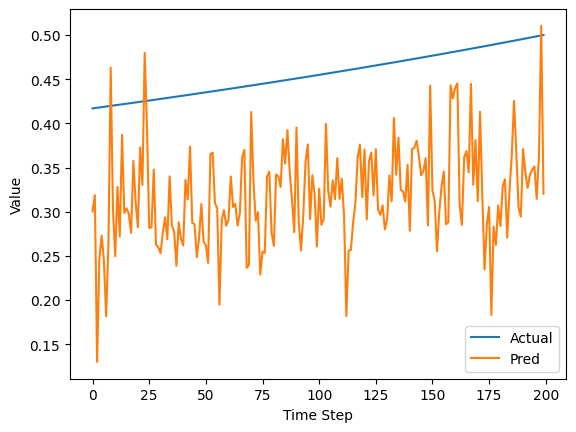

In [ ]:
print(test_ds[0]['target'][0][-prediction_length:])
test_0 = test_ds[0]['target'][0][-prediction_length:]
forecasts_0 = forecasts_test[0][0]
print(forecasts_0.shape)

plt.figure(2)
plt.plot(test_ds[0]['target'][0][-prediction_length:], label="Actual")
plt.plot(forecasts_0[:,0], label='Pred')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()

In [ ]:

print('forecast median',forecast_median)
print(test_ds[0]["target"][:][-4:])
print('ground truth', [test_ds[:]["target"][0][-prediction_length:], test_ds[:]["target"][0][-prediction_length:]])

NameError: name 'forecast_median' is not defined

In [ ]:
# Evaluate

from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

print(np.median(forecasts_test, 0).squeeze(0).shape)
forecast_median = np.median(forecasts_test, 0).squeeze(0)

mase_metrics_x = []
smape_metrics_x = []
mase_metrics_u = []
smape_metrics_u = []

for item_id, ts in enumerate(test_ds):
    training_data = [ts["target"][0][:-prediction_length], ts["target"][1][:-prediction_length]]
    ground_truth = [ts["target"][0][-prediction_length:], ts["target"][0][-prediction_length:]]
    
    print(training_data)
    print(ground_truth)
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

(4, 2)
[[0.0, 0.2567567527294159, 0.2638888955116272, 0.27142858505249023, 0.27941176295280457, 0.28787878155708313, 0.296875, 0.30645161867141724, 0.3166666626930237, 0.32758620381355286, 0.3392857015132904, 0.35185185074806213, 0.36538460850715637, 0.3799999952316284, 0.3958333432674408, 0.41304346919059753], [1.0, 0.18100996315479279, 0.23720760643482208, 0.29360902309417725, 0.35023218393325806, 0.4070972800254822, 0.46422696113586426, 0.5216468572616577, 0.5793859362602234, 0.6374773383140564, 0.69595867395401, 0.7548732757568359, 0.8142712712287903, 0.87421053647995, 0.9347587823867798, 0.9959954023361206]]
([0.0, 0.2567567527294159, 0.2638888955116272, 0.27142858505249023, 0.27941176295280457, 0.28787878155708313, 0.296875, 0.30645161867141724, 0.3166666626930237, 0.32758620381355286, 0.3392857015132904, 0.35185185074806213, 0.36538460850715637, 0.3799999952316284, 0.3958333432674408, 0.41304346919059753, 0.4318181872367859, 0.4523809552192688, 0.4749999940395355, 0.5], [1.0, 0.

ValueError: Predictions and/or references don't match the expected format.
Expected format: {'predictions': Value(dtype='float32', id=None), 'references': Value(dtype='float32', id=None)},
Input predictions: [-0.03864578  0.29298973],
Input references: [[0.         0.25675675 0.2638889  0.27142859 0.27941176 0.28787878
  0.296875   0.30645162 0.31666666 0.3275862  0.3392857  0.35185185
  0.36538461 0.38       0.39583334 0.41304347 0.43181819 0.45238096
  0.47499999 0.5       ]
 [1.         0.18100996 0.23720761 0.29360902 0.35023218 0.40709728
  0.46422696 0.52164686 0.57938594 0.63747734 0.69595867 0.75487328
  0.81427127 0.87421054 0.93475878 0.9959954  1.05801439 1.12092733
  1.18486845 1.25      ]]

In [ ]:
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

In [ ]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [ ]:
import matplotlib.dates as mdates


def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_ds[ts_index][FieldName.START],
        periods=len(test_ds[ts_index][FieldName.TARGET]),
        freq=test_ds[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[-2 * prediction_length :],
        test_ds[ts_index]["target"][mv_index, -2 * prediction_length :],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        forecasts_test[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.fill_between(
        index[-prediction_length:],
        forecasts_test[ts_index, ..., mv_index].mean(0)
        - forecasts_test[ts_index, ..., mv_index].std(axis=0),
        forecasts_test[ts_index, ..., mv_index].mean(0)
        + forecasts_test[ts_index, ..., mv_index].std(axis=0),
        alpha=0.2,
        interpolate=True,
        label="+/- 1-std",
    )
    ax.legend()
    fig.autofmt_xdate()


TypeError: tuple indices must be integers or slices, not tuple

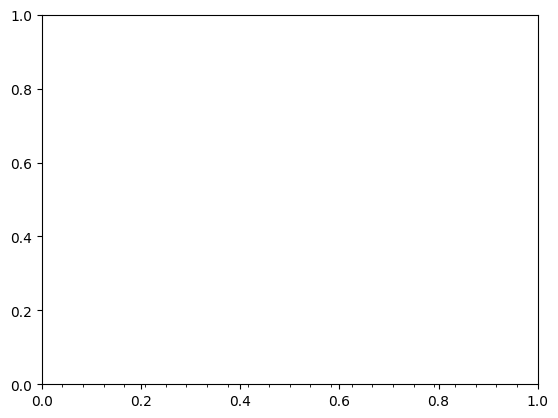

In [ ]:
plot(0, 2)